2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [2]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()
userArtistDF.show()

print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
print ('There are {} records in the data'.format(userArtistDF.count()))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
There are 24296858 records in the data


#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [164]:
uniqueUsers = userArtistDF.select('userID').distinct().count()
print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


***Comment:*** In this dataset there are 148111 different registered users.

#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [165]:
uniqueArtists = userArtistDF.select('artistID').distinct().count()
print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


***Comment:*** At this point, there are 1631028 different registered artists in the dataset but it does not mean that all these artists are unique. We have not explored through the entire data to see if there are misspelled names. 

#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [166]:
limitsUsers = userArtistDF.agg(min('userID'), max('userID'))
limitsUsers.show()

Int32max = 2147483648
Int32min = 0
if Int32min < limitsUsers.collect()[0][1] < Int32max:
    print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
    print ('Users IDs are in range of 32-bits')
else:
    print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
    print ('Users IDs are out of range of 32-bits')

+-----------+-----------+
|min(userID)|max(userID)|
+-----------+-----------+
|         90|    2443548|
+-----------+-----------+

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Users IDs are in range of 32-bits


***Comment:*** According to registred usersID, the range is between Integer 32, one will not have any problem to use it later in ALS recommendation.

#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [167]:
limitsartistID = userArtistDF.agg(min('artistID'), max('artistID'))
limitsartistID.show()

if Int32min < limitsartistID.collect()[0][1] < Int32max:
    print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
    print ('Artist IDs are in range of 32-bits')
else:
    print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
    print ('Artists IDs are out of range of 32-bits')

+-------------+-------------+
|min(artistID)|max(artistID)|
+-------------+-------------+
|            1|     10794401|
+-------------+-------------+

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Artist IDs are in range of 32-bits


***Comment:*** According to registred artistID, the range is between Integer 32, one will not have any problem to use it later in ALS recommendation.

We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many songs each user has heard? Show 5 samples of the result.
</div>

In [168]:
userActivity = userArtistDF.groupBy('userID').sum('playCount')

print ('All distinct users have heard the following total songs:')
userActivity.show(5)

All distinct users have heard the following total songs:
+-------+--------------+
| userID|sum(playCount)|
+-------+--------------+
|1000061|           244|
|1000070|         20200|
|1000313|           201|
|1000832|          1064|
|1000905|           214|
+-------+--------------+
only showing top 5 rows



Before going deeper, let me compute some basic characteristic such as mean and median to get an idea how the data is distributed.

In [169]:
# Median 50% quartile
medianUser = userActivity.approxQuantile('sum(playCount)', [0.5], 0.25)
# Mean
meanUser = userActivity.agg(mean('sum(playCount)'))

print ('The median n. played songs by user is {}'.format(medianUser[0], meanUser.collect()[0][0]))
print ('The mean n. played songs by user is {:.5}'.format(meanUser.collect()[0][0]))

The median n. played songs by user is 968.0
The mean n. played songs by user is 2509.2


***Comment:*** According to the results the mean and the median differ, so that means the distribution could be skewed. In the following question, a graph is showed to get an idea how data is spread along the number of plays.

#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

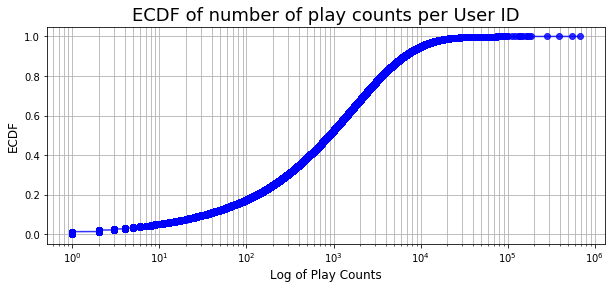

In [170]:
pdf_users = pd.DataFrame(data = userActivity.collect())
Y_users = np.sort(pdf_users[1])
yvals_users = np.arange(len(Y_users)) / float(len(Y_users))

# Plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
plt.plot(Y_users, yvals_users, '-bo', alpha=0.8)

plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID',fontsize=18)
plt.xlabel('Log of Play Counts', fontsize=12)
plt.ylabel('ECDF',fontsize=12)
ax.set_xscale('log')
plt.show()

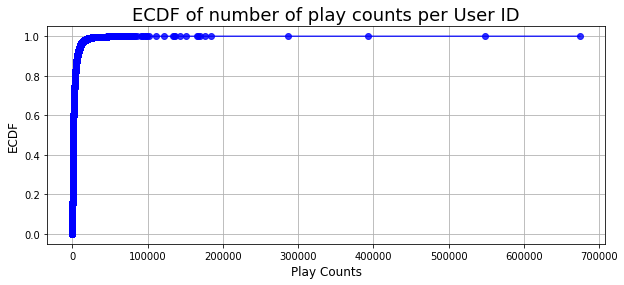

In [171]:
# Plot
fig = plt.figure(figsize=(10, 4))
plt.plot(Y_users, yvals_users, '-bo', alpha=0.8)

plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID',fontsize=18)
plt.xlabel('Play Counts', fontsize=12)
plt.ylabel('ECDF',fontsize=12)
plt.show()

***Comment:*** In this graphs it is visible that around 90% of the play counts are achieved around 10000 reproductions, meaning that around 10% of the users reproduce a large quantity of songs, while the rest hear much less. In the logarithmic scale graph one may clearly see that the probability of reaching approximately 900 play counts is around 0.5, which is the median, but due to extreme play count reproductions the distribution is skewed and the mean value is pulled approximately to 2500 play counts.

Text(0.5,0,'Play Counts')

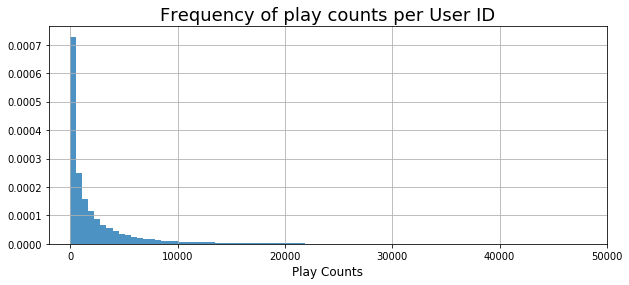

In [172]:
# Graph to show frequeny of play counts per User ID
fig = plt.figure(figsize=(10, 4))
plt.hist(Y_users, bins=1200, normed=True, alpha=0.8,
         edgecolor='none')

plt.grid(True,which="both",ls="-")
plt.title('Frequency of play counts per User ID',fontsize=18)
plt.xlim(-2000, 50000)
plt.xlabel('Play Counts', fontsize=12)

***Comment:*** The graph shows there are many users that heard a specific artist several times (repeatedly or without showing diversity) and few others that have heard a range of artist. It causes a final skew deviation from distribution. In other words, there are few users that hear specific songs many times and many other users that hear a variety of artists very little times.

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [173]:
artistPopularity = userArtistDF.groupBy('artistID').sum('playCount')

print ('Asumming at this point all artistID depicts unique song, each one has played the following times:')
artistPopularity.show(5)

Asumming at this point all artistID depicts unique song, each one has played the following times:
+--------+--------------+
|artistID|sum(playCount)|
+--------+--------------+
| 1109864|          5293|
| 1021335|         38933|
| 2121200|           853|
| 1010728|         45373|
| 1000311|          8123|
+--------+--------------+
only showing top 5 rows



***Comments:*** The number of played songs per artists can be ambiguous at this time because there is no certainty that all artistID depicts only a unique artist, so there could be play counts that refer to a same artist, but that have different IDs due to a misspelled name. If there are misspelled artist names then we need to standarize artists names so that the information and stats can be reliable. 

In [174]:
# Median 50% quartile
medianArtist = artistPopularity.approxQuantile('sum(playCount)', [0.5], 0.25)
# Mean
meanArtist = artistPopularity.agg(mean('sum(playCount)'))

print ('The median n. songs played by artist is {}'.format(medianArtist[0]))
print ('The mean n. songs played by artist is {:.5}'.format(meanArtist.collect()[0][0]))

The median n. songs played by artist is 3.0
The mean n. songs played by artist is 227.86


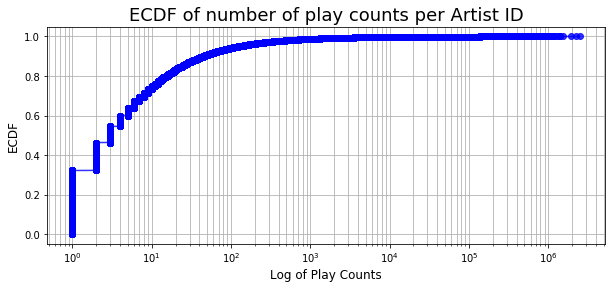

In [175]:
pdf_artist = pd.DataFrame(data = artistPopularity.collect())
Y_artist= np.sort(pdf_artist[1])
yvals_artist = np.arange(len(Y_artist)) / float(len(Y_artist))

# Plot
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
plt.plot(Y_artist, yvals_artist, '-bo', alpha=0.8)

plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID',fontsize=18)
plt.xlabel('Log of Play Counts', fontsize=12)
plt.ylabel('ECDF',fontsize=12)
ax.set_xscale('log')
plt.show()

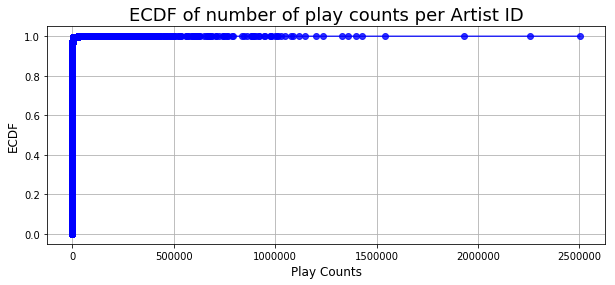

In [176]:
# Plot
fig = plt.figure(figsize=(10, 4))
plt.plot(Y_artist, yvals_artist, '-bo', alpha=0.8)

plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID',fontsize=18)
plt.xlabel('Play Counts', fontsize=12)
plt.ylabel('ECDF',fontsize=12)
plt.show()

***Comments:*** Again, we compute some basic stats features to get an idea how the artist column is distributed. The results show that the median and mean are different, meaning that the data is skewed. Now, we have not explored if all artistsIDs are unique. We will find out later there are some mispelled artists that may cause a big difference between the mean and the median.The results at this time show us there are few artists that are reproduced several times and many others that are heard fewer times. This cause a deviation between the mean and the median. 
The result of having this behavior with both the users and artists may lead to have a final recommendation matrix that could be sparse because there are too many artists who are reproduced more than others for users.

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul></div>

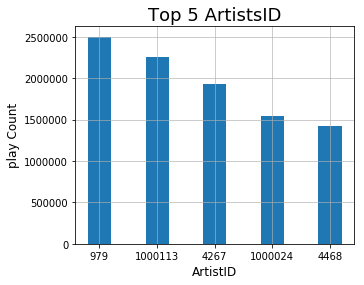

In [177]:
# Rename pandas DF columns
pdf_artist.columns = ['artistID', 'count']
# Sort DF by count
sortedArtist = pdf_artist.sort_values(by=['count'], ascending=[False])

# Plot
fig = plt.figure(figsize=(5, 4))
plt.grid(True,which="both",ls="-", alpha = 0.8)
plt.bar(np.arange(5), sortedArtist['count'][:5], 0.4, align='center')
plt.title('Top 5 ArtistsID',fontsize=18)
plt.xlabel('ArtistID', fontsize=12)
plt.ylabel('play Count',fontsize=12)
plt.xticks(np.arange(5), sortedArtist['artistID'][:5])
plt.show()

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [178]:
customSchemaArtist = StructType([ \
    StructField('artistID', LongType(), True), \
    StructField('name', StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + 'artist_data.txt', schema = customSchemaArtist) \
    .cache()
    
artistDF.cache()
artistDF.show(5)

print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
print ('There are {} artistID in the data'.format(artistDF.count()))

+--------+--------------------+
|artistID|                name|
+--------+--------------------+
| 1134999|        06Crazy Life|
| 6821360|        Pang Nakarin|
|10113088|Terfel, Bartoli- ...|
|10151459| The Flaming Sidebur|
| 6826647|   Bodenstandig 3000|
+--------+--------------------+
only showing top 5 rows

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
There are 1848172 artistID in the data


***Comments:*** In this table there are 1848172 artists, more than *200000 aprox* the first table loaded previously, meaning two things. The first there may exist some artists that users have never played before and secondly there many mispelled artists names in the artist_data.txt. Later, we will use another file, with the misspelled IDs, to solve the second problem and try to standarize names.

#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [179]:
# get artists whose name contains "Aerosmith"
artistDF[locate('Aerosmith', artistDF.name) > 0].show()

# show two examples
artistDF[artistDF.artistID==1000010].show()
artistDF[artistDF.artistID==2082323].show()


+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10586006|Dusty Springfield...|
| 6946007|    Aerosmith/RunDMC|
|10475683|Aerosmith: Just P...|
| 1083031|    Aerosmith/ G n R|
| 6872848|Britney, Nsync, N...|
|10586963|Green Day - Oasis...|
|10028830|The Aerosmith Ant...|
|10300357| Run-DMC + Aerosmith|
| 2027746|Aerosmith by Musi...|
| 1140418|[rap]Run DMC and ...|
|10237208| Aerosmith + Run DMC|
|10588537|Aerosmith, Kid Ro...|
| 9934757|Aerosmith - Big Ones|
|10437510|Green Day ft. Oas...|
| 6936680| RUN DNC & Aerosmith|
|10479781|      Aerosmith Hits|
|10114147|Charlies Angels -...|
| 1262439|Kid Rock, Run DMC...|
| 7032554|Aerosmith & Run-D...|
|10033592|          Aerosmith?|
+--------+--------------------+
only showing top 20 rows

+--------+---------+
|artistID|     name|
+--------+---------+
| 1000010|Aerosmith|
+--------+---------+

+--------+------------+
|artistID|        name|
+--------+------------+
| 2082323|01 Aerosmith|
+---

***Comments:*** As it is showed in the previous dataframe, there are many wrong entries for Aerosmith artist and much others. For example, the artistIDs *1000010 and 2082323* refer to the same artist, but are registered with two different IDs. The idea is to define one unique name to use it in the recommender model because otherwise the recommendation will be wrong.

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [180]:
customSchemaArtistAlias = StructType([ \
    StructField('misspelledArtistID', LongType(), True ), \
    StructField('standardArtistID', LongType(), True )])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_alias.txt", schema = customSchemaArtistAlias) \
    .cache()

artistAliasDF.show(5)

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
|           1092764|         1000311|
|           1095122|         1000557|
|           6708070|         1007267|
|          10088054|         1042317|
|           1195917|         1042317|
+------------------+----------------+
only showing top 5 rows



***Comment:*** Now a table containing the misspelled IDs referencing to the correct artist IDs is used to fix and use a standard name of all artists. After clearning all artists, the final *userID, artistID, playCount* table must contain duplicate rows for a specific user and artist. Afterwards we will merge all these entries and we will keep a final dataframe with unique artists to use it during predictions recommender system.

#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [181]:
artistAliasDF[artistAliasDF.misspelledArtistID == 1000010].show()
artistAliasDF[artistAliasDF.misspelledArtistID == 2082323].show()

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
+------------------+----------------+

+------------------+----------------+
|misspelledArtistID|standardArtistID|
+------------------+----------------+
|           2082323|         1000010|
+------------------+----------------+



***Comments:*** For example in this query, one can see that the artist ID *1000010* does not appear as a misspelled artist ID, because it is the ID of the standard artist name, while the second one *2082323* is in this table, meaning that it represents a wrong artist name and will be changed by the standard one.

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [182]:
# Dictionary of misspelled artists
artistAlias = artistAliasDF.rdd.map(lambda row: (row[0],row[1])).collectAsMap()

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [183]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(lambda row: replaceMispelledIDs(row)), 
    userArtistDataSchema)

newUserArtistDF.show(5)

t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.916538 seconds


Now we will perfom a query to see if there are duplicate rows because of replacing by the standard artists names.

In [184]:
# Count those rows which are duplicate after replacing by standarized artist name
newUserArtistDF_name = newUserArtistDF\
                        .groupBy('userID', 'artistID')\
                        .count()\
                        .where('count > 1')

# The following shows 5 random samples from previous table to add the artist name
newUserArtistDF_name\
            .sample(False, 0.1, seed=0)\
            .limit(5)\
            .join(artistDF, newUserArtistDF_name.artistID == artistDF.artistID)\
            .drop(artistDF.artistID)\
            .show()

+-------+--------+-----+------------------+
| userID|artistID|count|              name|
+-------+--------+-----+------------------+
|1004580| 7006467|    2|         Henrik T.|
|1004332|10615102|    2|               高橋瞳|
|1000197| 1000094|    2|The Bouncing Souls|
|1001790| 1004924|    2|      Robert Miles|
|1021969| 1002065|    2|    Paul Oakenfold|
+-------+--------+-----+------------------+



***Comments:*** After replacing misspelled by standard artistsID names, the following query proves that the first user has registered the artist (artistID) in different rows, indicating that the artistID has many playCounts with the same user. So, the misspelledIDs have been replace with the correct ones, now we have to merge this rows to have unique correspondance between users with artists.

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [185]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1] , fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)
t1 = time()

print('The script takes %f seconds' %(t1-t0))

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows

The script takes 0.203205 seconds


***Comment***: The same piece of code is run again adding artistAlias dictionary as a broadcasting variable. In terms of computation speed, this solution runs much faster than the previous one because all workers now share the same dictionary having to interchange less data between each others.

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

***Comment:*** Next, we will merge all duplicate rows to have a compact table with just one playCount row per each userID and artistID.

In [186]:
# Sum and merge rows which have the same standarized artistID
newUserArtistDF = newUserArtistDF\
                        .groupBy('userID', 'artistID')\
                        .sum('playCount')

# Rename it the sum playCount column as total playCount
newUserArtistDF = newUserArtistDF\
                        .select('userID', 'artistID', col('sum(playCount)')\
                        .alias('playCount'))

print ('The new user artist table after merging duplicating rows are:')
newUserArtistDF.show(5)     

The new user artist table after merging duplicating rows are:
+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2286103| 1000429|       13|
|2286103| 1001003|        4|
|2286108| 1019236|        3|
|2286110| 1002991|       48|
|2286110| 1037969|       11|
+-------+--------+---------+
only showing top 5 rows



The following query shows there are not exist duplicate rows.

In [187]:
# After merging, are still duplicate rows?
newUserArtistDF.groupBy('userID', 'artistID').count().where('count > 1').show()


+------+--------+-----+
|userID|artistID|count|
+------+--------+-----+
+------+--------+-----+



***Comment:*** Now there are no duplicate rows containing the same artistID for each userID with different play counts, the merge left just one play count per each artist.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [188]:
uniqueNewArtist = newUserArtistDF.select('artistID').distinct().count()
print("Total n. of artists: ", uniqueNewArtist)

Total n. of artists:  1568126


***Comment:*** After cleaning all arstist IDs from the original dataset, there are fewer unique names in the dataset (-100000 aprox). Now it is possible to explore some users preferences according to what kind of music they like, how many times they listen to it and so on. Having a more standarized dataset, with fewer artists and after correcting the misspelled ones, we can expect a better performance of suggestions when building the recommendation matrix.

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

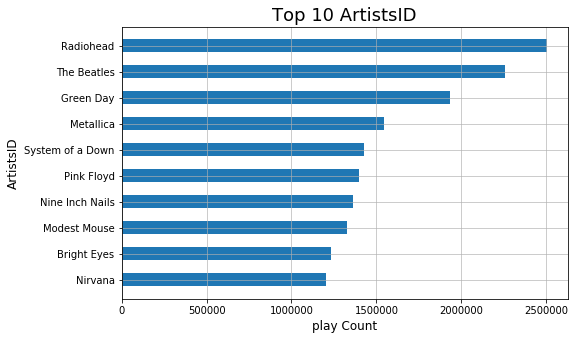

In [189]:
# The top 10 in terms of absolute play counts are
top10ArtistsPC = newUserArtistDF\
                    .groupBy('artistID')\
                    .sum('playCount')\
                    .orderBy('sum(playCount)', ascending=0)\
                    .limit(10)

# Merge the top 10 results with artists names
top10ArtistsPC_name = artistDF\
                    .join(top10ArtistsPC, artistDF.artistID == top10ArtistsPC.artistID)\
                    .drop(top10ArtistsPC.artistID)

# Transform as pandas dataframe and sort per playCount
pdfArtistsPC = pd.DataFrame(data = top10ArtistsPC_name.collect())
pdfArtistsPC.columns = ['userID', 'artistID', 'count']
pdfArtistsPC = pdfArtistsPC.sort_values(by=['count'], ascending=[True])

# Plot
fig = plt.figure(figsize=(8, 5))
plt.grid(True,which="both",ls="-", alpha = 0.8)
plt.barh(np.arange(len(pdfArtistsPC)), pdfArtistsPC['count'], 0.5, align='center')
plt.title('Top 10 ArtistsID',fontsize=18)
plt.xlabel('play Count', fontsize=12)
plt.ylabel('ArtistsID',fontsize=12)
plt.yticks(np.arange(len(pdfArtistsPC)), pdfArtistsPC['artistID'])
plt.show()

***Comment***: In the above plot, Radiohead seems to be in the first place of most reproduced artists in general. The result is coherent with real facts. The artist who are showed above are well-know bands/groups. At least one must have heard one song of these artists once in his/her life but coincidentialy it seems to be a hidden factor such as a the eligibility of rock gender among all people. In general terms, rock gender has many other derivations but as a simple clause, is possible to group top 10 users such that they prefer rock instead of others.

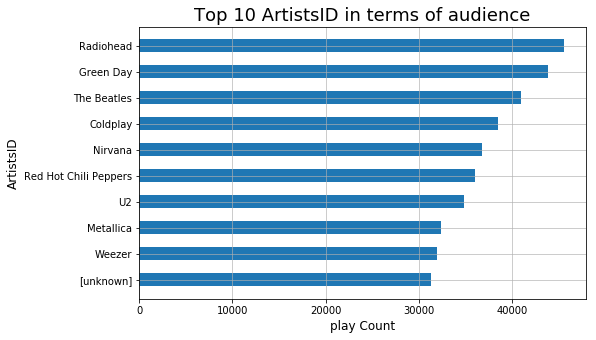

In [190]:
# Add new column per unique userID (1 of playCount > 1 or 0 otherwise)
top10Audience = newUserArtistDF\
                    .withColumn('audience', when(newUserArtistDF['playCount'] > 0, 1)\
                    .otherwise(0))

top10Audience = top10Audience\
                    .groupBy('artistID')\
                    .sum('audience')\
                    .orderBy('sum(audience)', ascending=0)\
                    .limit(10)
            
# Merge the top 10 results with artists names
top10Audience_name = artistDF\
                    .join(top10Audience, artistDF.artistID == top10Audience.artistID)\
                    .drop(top10Audience.artistID)

# Transform as pandas dataframe and sort per playCount
pdfAudience = pd.DataFrame(data = top10Audience_name.take(20))
pdfAudience.columns = ['userID', 'artistID', 'count']
pdfAudience = pdfAudience.sort_values(by=['count'], ascending=[True])

# Plot
fig = plt.figure(figsize=(8, 5))
plt.grid(True,which="both",ls="-", alpha = 0.8)
plt.barh(np.arange(len(pdfAudience)), pdfAudience['count'], 0.5, align='center')
plt.title('Top 10 ArtistsID in terms of audience',fontsize=18)
plt.xlabel('play Count', fontsize=12)
plt.ylabel('ArtistsID',fontsize=12)
plt.yticks(np.arange(len(pdfAudience)), pdfAudience['artistID'])
plt.show()

***Comments:*** This query is very importat because reflects the numbers of most listened artists per single user. In general terms, a large number of users have heard at least one of these artists. The artists that are presented above could be one of the recommendations for other users. In the last part of the notebook, we will discover whether at least one of these artists appears as a recommendations for other users. 

Also is possbile to see that there is an artist named *unknown* (the last one, it seemns the data is not totally clean). It is necessary to remove it to recommend real artist to users.

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

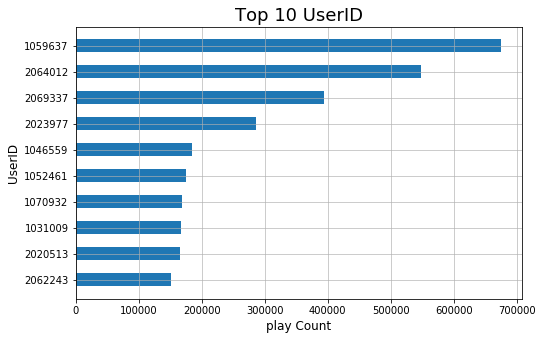

In [191]:
top10Users = newUserArtistDF\
                    .groupBy('userID')\
                    .sum('playCount')\
                    .orderBy('sum(playCount)', ascending=0)\
                    .limit(10)

# Transform as pandas dataframe and sort per playCount
pdftopUsers = pd.DataFrame(data = top10Users.collect())
pdftopUsers.columns = ['userID', 'count']
pdftopUsers = pdftopUsers.sort_values(by=['count'], ascending=[True])

# Plot
fig = plt.figure(figsize=(8, 5))
plt.grid(True,which="both",ls="-", alpha = 0.8)
plt.barh(np.arange(len(pdftopUsers)), pdftopUsers['count'], 0.5, align='center')
plt.title('Top 10 UserID',fontsize=18)
plt.xlabel('play Count', fontsize=12)
plt.ylabel('UserID',fontsize=12)
plt.yticks(np.arange(len(pdftopUsers)), pdftopUsers['userID'])
plt.show()

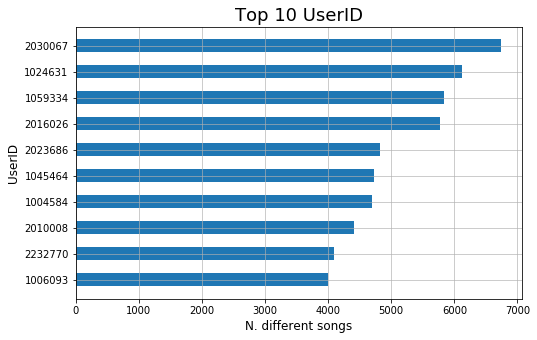

In [192]:
# Add new column per unique userID (1 of unique artist > 1 or 0 otherwise) (becuase the dataframe...)
# ... does not contain duplicates, in our case, each artist can be assigened 1.
top10Curiosity = newUserArtistDF\
                    .withColumn('curiosity', when(newUserArtistDF['artistID'] > 0, 1)\
                    .otherwise(0))
    
# Group and count userID
top10Curiosity = top10Curiosity\
                    .groupBy('userID')\
                    .sum('curiosity')\
                    .orderBy('sum(curiosity)', ascending=0)\
                    .limit(10)

# Transform as pandas dataframe and sort per playCount
pdftopCuriosity = pd.DataFrame(data = top10Curiosity.collect())
pdftopCuriosity.columns = ['userID', 'count']
pdftopCuriosity = pdftopCuriosity.sort_values(by=['count'], ascending=[True])

# Plot
fig = plt.figure(figsize=(8, 5))
plt.grid(True,which="both",ls="-", alpha = 0.8)
plt.barh(np.arange(len(pdftopCuriosity)), pdftopCuriosity['count'], 0.5, align='center')
plt.title('Top 10 UserID', fontsize=18)
plt.xlabel('N. different songs', fontsize=12)
plt.ylabel('UserID',fontsize=12)
plt.yticks(np.arange(len(pdftopCuriosity)), pdftopCuriosity['userID'])
plt.show()

***Comment:*** The last two plots are really interesting. In conclusion one could say that the user who reproduces several times a specific song is not the one who shows diversity among artists. To understand visually the last two queries, let's take a sample for a particular user from each group, to see how many different songs he/she hear in order to discover which gender he/she may like.

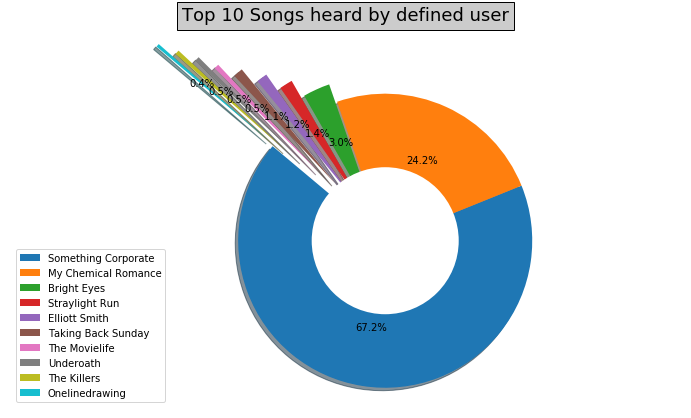

In [193]:
# Choose one userID
idUser = 1059637

# 10 most heard unique artists from user choosen before
Top10mostHearbyUser = newUserArtistDF[newUserArtistDF.userID==idUser]\
                        .groupBy('artistID')\
                        .sum('playCount')\
                        .orderBy('sum(playCount)', ascending=0)\
                        .limit(10)
                
# Match artistID with real name
Top10mostHearbyUser_name = artistDF\
                    .join(Top10mostHearbyUser, artistDF.artistID == top10Audience.artistID)\
                    .drop(Top10mostHearbyUser.artistID)
            
# Transform as pandas dataframe and sort per playCount
pdfTop10mostHear = pd.DataFrame(data = Top10mostHearbyUser_name.collect())
pdfTop10mostHear.columns = ['artistID', 'name', 'count']
pdfTop10mostHear = pdfTop10mostHear.sort_values(by=['count'], ascending=[False])

# Find explode best configuration for pie plot according to results
pieList = np.array(pdfTop10mostHear['count']/np.max(pdfTop10mostHear['count']))
explode = [0] * len(pieList)

i = val = 0
criteria = 0.2
for i in range(len(pieList)):
    if pieList[i] < criteria:
        val += 0.13
        explode[i] = val

# Plot
fig = plt.figure(figsize=(12, 7))
labels = pdfTop10mostHear['name']
fracs = pdfTop10mostHear['count']

plt.pie(fracs, explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
centre_circle = plt.Circle((0,0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.legend(labels=labels, loc="best")
plt.axis('equal')
plt.title('Top 10 Songs heard by defined user', fontsize=18, bbox={'facecolor':'0.8', 'pad':5})
plt.show()           

***Comment:*** In this graph it is represented the hearing preferences from the user with the highest play count. This user has very little diversity in artists despite having a high reproduction count. It is possible that the recommendations for this user may not present too much diversity also.

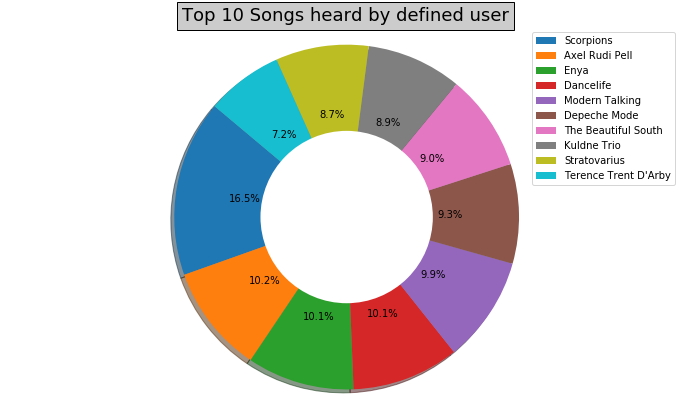

In [194]:
# Choose one userID
idUser = 2030067

# 10 most heard unique artists from user choosen before
Top10mostHearbyUser = newUserArtistDF[newUserArtistDF.userID==idUser]\
                        .groupBy('artistID')\
                        .sum('playCount')\
                        .orderBy('sum(playCount)', ascending=0)\
                        .limit(10)
                
# Match artistID with real name
Top10mostHearbyUser_name = artistDF\
                    .join(Top10mostHearbyUser, artistDF.artistID == top10Audience.artistID)\
                    .drop(Top10mostHearbyUser.artistID)
            
# Transform as pandas dataframe and sort per playCount
pdfTop10mostHear = pd.DataFrame(data = Top10mostHearbyUser_name.collect())
pdfTop10mostHear.columns = ['artistID', 'name', 'count']
pdfTop10mostHear = pdfTop10mostHear.sort_values(by=['count'], ascending=[False])

# # Find explode best configuration for pie plot according to results
# pieList = np.array(pdfTop10mostHear['count']/np.max(pdfTop10mostHear['count']))
# explode = [0] * len(pieList)

# i = val = 0
# criteria = 0.2
# for i in range(len(pieList)):
#     if pieList[i] < criteria:
#         val += 0.13
#         explode[i] = val

# Plot
fig = plt.figure(figsize=(12, 7))
labels = pdfTop10mostHear['name']
fracs = pdfTop10mostHear['count']

plt.pie(fracs, autopct='%1.1f%%', shadow=True, startangle=140)
centre_circle = plt.Circle((0,0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.legend(labels=labels, loc="best")
plt.axis('equal')
plt.title('Top 10 Songs heard by defined user', fontsize=18, bbox={'facecolor':'0.8', 'pad':5})
plt.show()           

***Comment:*** In order to have a better clean dataset of the artists, the *unknown* and *various* artists are being located first and then removed from newUserArtistID spark dataframe.

In [195]:
# Locate Artists with unknown, varios artists names
unknownArtistID = artistDF[(locate('unknown', artistDF.name) > 0) | (locate('various', artistDF.name)>0)]
print('Fist 20 weird name artists:')
unknownArtistID.show()

# Select artistID of the unknown artists
unknownArtistID = unknownArtistID.select('artistID')

# The unknown artists are 'removed' from the dataframe used
newUserArtistDF = newUserArtistDF\
                        .join(unknownArtistID, newUserArtistDF.artistID == unknownArtistID.artistID, 'leftanti')
    
print('newUserArtist Dataframe after removing unknow artists:')
newUserArtistDF.show(10)

Fist 20 weird name artists:
+--------+--------------------+
|artistID|                name|
+--------+--------------------+
|10475399|      various - funk|
| 1086205|          20 various|
| 1241058|     track13 unknown|
| 1241060|     track14 unknown|
| 1241061|     track15 unknown|
| 1241062|     track16 unknown|
| 1241084|     track02 unknown|
| 6990831|        unknown tone|
| 6827178|hyperunknown & co...|
| 1140451|           @unknown@|
|10476195|bounty killer ft ...|
| 1253193|   1. origin unknown|
| 1253199|   5. origin unknown|
| 1253214|   9. origin unknown|
| 1253217|  10. origin unknown|
| 1255078|09 various artist...|
| 6860439|      Ethnic various|
|10438620|heltah skeltah wi...|
| 6860295|    [unknown artist]|
|10595499|  various achterhook|
+--------+--------------------+
only showing top 20 rows

newUserArtist Dataframe after removing unknow artists:
+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|2096216|      26|        1|
|211384

In [196]:
newUserArtistDFCount = newUserArtistDF.select('artistID').distinct().count()
print("Total n. of artists: ", newUserArtistDFCount)

Total n. of artists:  1567695


***Comment:***We have seen the cleaning process is not an easy task. It may lead to consume a lot time and still there is not a certainty that all artists represent real artist name. But for now there are fewer artists in the dataset which we will use to crate the recommendation matrix.

The following plot recreates the same query as bar plot with top 10 artist in terms of audiece after removing unknow artists.

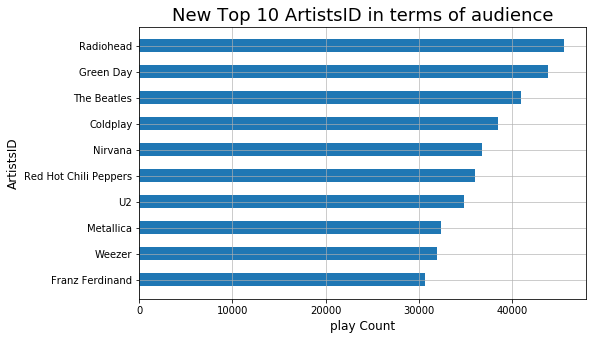

In [197]:
# Add new column per unique userID (1 of playCount > 1 or 0 otherwise)
top10Audience = newUserArtistDF\
                    .withColumn('audience', when(newUserArtistDF['playCount'] > 0, 1)\
                    .otherwise(0))

top10Audience = top10Audience\
                    .groupBy('artistID')\
                    .sum('audience')\
                    .orderBy('sum(audience)', ascending=0)\
                    .limit(10)
            
# Merge the top 10 results with artists names
top10Audience_name = artistDF\
                    .join(top10Audience, artistDF.artistID == top10Audience.artistID)\
                    .drop(top10Audience.artistID)

# Transform as pandas dataframe and sort per playCount
pdfAudience = pd.DataFrame(data = top10Audience_name.take(20))
pdfAudience.columns = ['userID', 'artistID', 'count']
pdfAudience = pdfAudience.sort_values(by=['count'], ascending=[True])

# Plot
fig = plt.figure(figsize=(8, 5))
plt.grid(True,which="both",ls="-", alpha = 0.8)
plt.barh(np.arange(len(pdfAudience)), pdfAudience['count'], 0.5, align='center')
plt.title('New Top 10 ArtistsID in terms of audience',fontsize=18)
plt.xlabel('play Count', fontsize=12)
plt.ylabel('ArtistsID',fontsize=12)
plt.yticks(np.arange(len(pdfAudience)), pdfAudience['artistID'])
plt.show()

***Comment:*** The new Top 10 Artists after taking out the unknown artists. In these top 10 the *unknown* artists that appeared before was replaced with *Franz Ferdinand*. Having the unknow artists removed will have a positive impact in the recommendations considering that a recommendation of an *unknown* artist will not be wanted by an user because it would not represent a real artist.

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [198]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( lambda s: xtractFields(s) )
    
                    # fileter out the special tuples
                    .filter( lambda row: row!=(-1,-1) )
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )


In the previous script, we drop rows which are not correctly filled and cortain empty values. If the model is trained without clearning them, we will raise an error.

#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

In [199]:
bArtistAlias = sc.broadcast(artistAlias)
# The following dataset is not clean ***
# rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(row):
    userID, artistID, count = row[0], row[1], row[2]
    finalArtistID = bArtistAlias.value.get(artistID, artistID)
    return (userID, finalArtistID, count)

userArtistDataRDD = newUserArtistDF.rdd.map(disambiguate)

***Comment:*** In the last process, we used the dataframe which we removed unkown artirts, duplicate rows after replacing standard artists and so on. We will use this RDD to train the stats model. 

In [200]:
print (type(userArtistDataRDD))
userArtistDataRDD.take(5)

<class 'pyspark.rdd.PipelinedRDD'>


[(2025018, 26, 20),
 (2048204, 26, 3),
 (2278428, 26, 2),
 (1052430, 26, 5),
 (2341917, 26, 1)]

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [201]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [202]:
# Because we already agregated duplicate rows before, we will proceed to cache userArtistDataRDD
allData = userArtistDataRDD.map(lambda r: Rating(r[0], r[1], r[2])).repartition(12).cache()

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [203]:
t0 = time()
model = ALS.trainImplicit(allData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 121.608610 secs


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [78]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save(sc , "lastfm_model.spark")

Deleted lastfm_model.spark


#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [79]:
t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model.spark")
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 3.414602 secs


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [204]:
model.userFeatures().first()

(90,
 array('d', [-0.491258829832077, 1.0908458232879639, -0.0305494274944067, -0.6179437637329102, -0.566020667552948, 0.09022194892168045, -0.18196319043636322, 0.03101210482418537, 0.9850337505340576, -0.02796659804880619]))

***Comments:*** The first row contain all User matrix estimated values by the model. These values will be used later to multiply by Item rows to fill empty values in the recommendation matrix.

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [205]:
# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760, 5))
# construct set of recommendated artists
recArtist = set(row.product for row in recommendations)
print(recArtist)

{1300642, 1811, 1001819, 4605, 2814}


In [206]:
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

Before to get the top 5 recommender artists for user 2093760, let's get an idea what are the most listened songs for this user to later compare it later with the training model. For that purpose, we will use the exact piece of code presented above during data exploration.

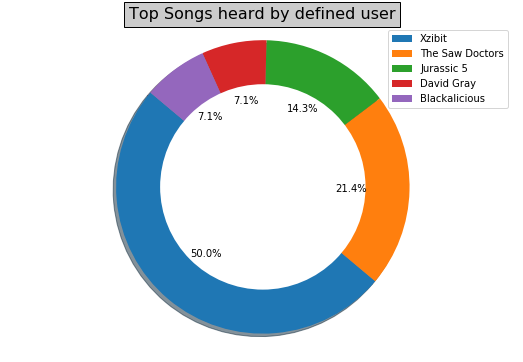

In [207]:
# Choose one userID
idUser = 2093760

# 10 most heard unique artists from user choosen before
Top10mostHearbyUser = newUserArtistDF[newUserArtistDF.userID==idUser]\
                        .groupBy('artistID')\
                        .sum('playCount')\
                        .orderBy('sum(playCount)', ascending=0)\
                        .limit(10)
                
# Match artistID with real name
Top10mostHearbyUser_name = artistDF\
                    .join(Top10mostHearbyUser, artistDF.artistID == top10Audience.artistID)\
                    .drop(Top10mostHearbyUser.artistID)
            
# Transform as pandas dataframe and sort per playCount
pdfTop10mostHear = pd.DataFrame(data = Top10mostHearbyUser_name.collect())
pdfTop10mostHear.columns = ['artistID', 'name', 'count']
pdfTop10mostHear = pdfTop10mostHear.sort_values(by=['count'], ascending=[False])

# # Find explode best configuration for pie plot according to results
# pieList = np.array(pdfTop10mostHear['count']/np.max(pdfTop10mostHear['count']))
# explode = [0] * len(pieList)

# i = val = 0
# criteria = 0.2
# for i in range(len(pieList)):
#     if pieList[i] < criteria:
#         val += 0.13
#         explode[i] = val

# Plot
fig = plt.figure(figsize=(9, 6))
labels = pdfTop10mostHear['name']
fracs = pdfTop10mostHear['count']

plt.pie(fracs, autopct='%1.1f%%', shadow=True, startangle=140)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.legend(labels=labels, loc="best")
plt.axis('equal')
plt.title('Top Songs heard by defined user', fontsize=16, bbox={'facecolor':'0.8', 'pad':5})
plt.show()           

According to Wikipedia, Xzibit, Juassic 5 are alternative hip hop groups. It seems this specific user has a tendency for such kind of gender music. Now let's gonna explore and predict the top 5 artist.

In [208]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(lambda line: artistNames(line)).values().collect()

print ('The model recommends the following artists:')
print(recList)

The model recommends the following artists:
['50 Cent', 'Snoop Dogg', 'Dr. Dre', '2Pac', 'The Game']


Cool !! The results show similarities according user's preferences. The recommender list are also aligned or categorized as hip hop singles/groups. The model is doing a great job. 

Now we will play with more users. What if we are trying to predict artists for those users we explored before. We mean user 1059637 who loves Something Corporate and My Chemical Romance and user 2030067 who shows a variety such as Scorpions, Axel Rudi, Enya and more. 

In [209]:
# Make five reccommendations to user 1059637
recommendations = (model.recommendProducts(1059637, 5))
recArtist = set(row.product for row in recommendations)

recList = artistByID.filter(lambda line: artistNames(line)).values().collect()

print ('The model recommends the following artists for user 1059637:')
print(recList)

The model recommends the following artists for user 1059637:
['Phantom Planet', 'The Ataris', 'The All-American Rejects', 'Tegan and Sara', 'Sugarcult']


In [210]:
# Make five reccommendations to user 2030067
recommendations = (model.recommendProducts(2030067, 5))
recArtist = set(row.product for row in recommendations)

recList = artistByID.filter(lambda line: artistNames(line)).values().collect()

print ('The model recommends the following artists for user 2030067:')
print(recList)

The model recommends the following artists for user 2030067:
['ABBA', 'a-ha', 'Various Artists', 'Theme Songs', 'Bee Gees']


***Comment:*** The recommender artist for user 1059637 are more pointed for irish rock bands ann related. This information is aligned with his/her preferences we showed before in the pie bar chart. The second user 2030067 has more tendency for rock-pop artist (at least wikipedia categorized most recommender artists like that) and also are related with that he/she hear. 

Until know the recommender model has done a great job but it's time to continue optimizing hyperparameters to see how recommender artists changes or not.

<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [211]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [212]:
(trainData, cvData) = allData.randomSplit([0.8, 0.2])
trainData.cache()
cvData.cache()

PythonRDD[1380] at RDD at PythonRDD.scala:48

In [213]:
t0 = time()
model = ALS.trainImplicit(trainData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 59.571230 secs


#### Area under the ROC curve: a function to compute it

In [214]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [215]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [216]:
t0 = time()
auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)
t1 = time()
print('Auc = {:.4}'.format(auc))
print('Finish in %f seconds' % (t1 - t0))

Auc = 0.9639
Finish in 74.893401 seconds


#### Question 9.3
<div class="alert alert-info">
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [217]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(lambda x, y: x + y).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get(r[1], 0.0)))

In [218]:
auc = calculateAUC(predictMostListened(allData), bAllItemIDs, predictMostListened)
print('Auc = {:.4}'.format(auc))

Auc = 0.9536


***Comment:*** The first impression is there's not much difference between the recommender ALS system and popularity based prediction. The evaluation metric AUC is relative the same but it does not. A lot of companies who use recommender system invests tons of money to improve a slighlty percentage the accuracy of the model. But at this time we are comparing a model with arbitrary hyperparameters and a simple aproach. Another step in ML models is to optmize values trying to avoid overtting and to generalize the model. The last task in very hard because depends of a lot of factor (data, complexity, so on). 

However there are techniques to try to generalize a ML model. One of them is Cross Validator. We will presente a native implementation in sparl for ALS. The only problem is it does not have AUC as evaluator metric. 

The AUC metric has an amazing property that is unsensible of data distribution in contrast with RMSE where the metric does not reflect reality if data distribution does not follow a guassian distribution. That means if data is skewed, the AUC performs better.

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

In [32]:
# Split data to train, validate and test
(trainData, valiData, testData) = allData.randomSplit([0.6, 0.2, 0.2])

# Range of values to be optimized
rank = [10, 25, 35, 50]
lambda_ = [0.0001, 0.001, 0.01, 0.1, 0.9]
alpha = [1.0, 15.0, 30.0, 40.0]

# Create all possible combinations among values
from itertools import product
comb = list(product(rank, lambda_, alpha))

# Initials values for optimizer
errors = [0] * len(comb)
err = 0
min_error = float('-inf')
best_rank = -1
best_lambda = -1
best_alpha = -1

for i in range(0, len(comb)):
    # Train model
    model = ALS.trainImplicit(trainData, rank=comb[i][0], iterations=5, lambda_=comb[i][1], alpha=comb[i][2])
    # Accuracy metric
    auc = calculateAUC(valiData, bAllItemIDs, model.predictAll)
    errors[err] = auc
    err += 1
    print ('Rank: {}\t\tlambda: {}\t\talpha: {}\t\tAUC: {:.4}'.format(comb[i][0], comb[i][1], comb[i][2], auc))
    
    # Select best model 
    if auc > min_error:
        min_error = auc
        best_rank, best_lambda, best_alpha = comb[i][0], comb[i][1], comb[i][2]

print()
print ('The best model is:  rank {}, lambda: {}, alpha: {}'.format(best_rank, best_lambda, best_alpha))


Rank: 10		lambda: 0.0001		alpha: 1.0		AUC: 0.9566
Rank: 10		lambda: 0.0001		alpha: 15.0		AUC: 0.9675
Rank: 10		lambda: 0.0001		alpha: 30.0		AUC: 0.971
Rank: 10		lambda: 0.0001		alpha: 40.0		AUC: 0.9696
Rank: 10		lambda: 0.001		alpha: 1.0		AUC: 0.9583
Rank: 10		lambda: 0.001		alpha: 15.0		AUC: 0.971
Rank: 10		lambda: 0.001		alpha: 30.0		AUC: 0.9699
Rank: 10		lambda: 0.001		alpha: 40.0		AUC: 0.9709
Rank: 10		lambda: 0.01		alpha: 1.0		AUC: 0.9593
Rank: 10		lambda: 0.01		alpha: 15.0		AUC: 0.9678
Rank: 10		lambda: 0.01		alpha: 30.0		AUC: 0.9701
Rank: 10		lambda: 0.01		alpha: 40.0		AUC: 0.9717
Rank: 10		lambda: 0.1		alpha: 1.0		AUC: 0.9595
Rank: 10		lambda: 0.1		alpha: 15.0		AUC: 0.9678
Rank: 10		lambda: 0.1		alpha: 30.0		AUC: 0.9709
Rank: 10		lambda: 0.1		alpha: 40.0		AUC: 0.9712
Rank: 10		lambda: 0.9		alpha: 1.0		AUC: 0.964
Rank: 10		lambda: 0.9		alpha: 15.0		AUC: 0.9697
Rank: 10		lambda: 0.9		alpha: 30.0		AUC: 0.9708
Rank: 10		lambda: 0.9		alpha: 40.0		AUC: 0.9714
Rank: 25		lambda: 0.0001

*** Comment:*** The ALS recommender algorithm is run for many posisble combination of hyperparameters. During the process, there is not direct correlation showing that an increase of rank size improves the accurancy. Sometimes is even worst. A similar behavior is observed with all others parameters. The accuracy metric AUC for all cases is around [0.96 0.97] with some decimals of difference.

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [219]:
# Train model
model = ALS.trainImplicit(allData, rank=10, iterations=5, lambda_=0.01, alpha=40.0)

# Data unpersist
allData.unpersist()

# Recommendation
userID = 2093760
recommendations = (model.recommendProducts(userID, 5))
# construct set of recommendated artists
recArtist = set(row.product for row in recommendations)

# Match artistID with numbers
recommendedProductIDs = artistByID\
                .filter(lambda line: artistNames(line))\
                .values().collect()

print ('The model recommends the following artists for user 1059637:')
print(recommendedProductIDs)

The model recommends the following artists for user 1059637:
['50 Cent', 'Jay-Z', '2Pac', 'Eminem', 'Green Day']


In [220]:
unpersist(model)

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)